In [1]:
import numpy as np
#####################################
import torch
import torch.nn as nn
#import torch.nn.functional as F
from torch import optim, autograd
#####################################
from matplotlib import pyplot as plt

**Radom selection of points in the domain**

In [2]:
def get_interior_points(N=64,d=1):
    """
    randomly sample N points from interior of [0,1]^d
    """
    aux = torch.rand(N,d)
    return aux

**RHS definition**

In [3]:
def f_rhs(x):
    aux = (np.pi)**2*torch.sin(np.pi*x)
    return aux

**CPU or GPU usage**

In [4]:
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Is cuda available?',torch.cuda.is_available())
print('Used device:',device)

Is cuda available? True
Used device: cpu


**Training and ANN parameters**

In [5]:
epochs = 50000 #50000

in_N = 1
m = 10
out_N = 1

**ANN initialization**

In [6]:
torch.manual_seed(42)
model = torch.nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,20),
    nn.Sigmoid(),    
    nn.Linear(20,20),
    nn.Sigmoid(),
    nn.Linear(20,20),
    nn.Sigmoid(),
    nn.Linear(20,10),
    nn.Sigmoid(),   
    nn.Linear(10,1)
)
#model.state_dict()

**Initial weights visualization**

In [7]:
#model.state_dict()

**Training method**

In [8]:
optimizer = optim.Adam(model.parameters(), lr=3e-3)

**Training step**

In [9]:
best_loss, best_epoch = 1000, 0
loss_vector = []
for epoch in range(epochs+1):
    # Random interior points
    x_int = get_interior_points()
    # Boundary points (1D case)
    x_bound = torch.tensor([[0.],[1.]])
    
    #
    #x_int   = x_int.to(device)   # ?
    #x_bound = x_bound.to(device) # ?
    # 
    x_int.requires_grad_()
    # ANN evaluation for interior points
    output_int = model(x_int)
    # ANN evaluation for boundary points
    output_bound = model(x_bound)
    # Gradient compudation 
    grads = autograd.grad(outputs=output_int, inputs=x_int,
                          grad_outputs=torch.ones_like(output_int),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    # Loss function (1st component)
    loss_int = 0.5*torch.pow(grads, 2) - f_rhs(x_int)*output_int
    loss_int = torch.mean(loss_int)
    # Loss function (2nd component)
    loss_bound = torch.mean(torch.pow(output_bound,2))
    # Loss function
    loss = loss_int + 500*loss_bound
    
    # Clear previous gradient computation
    optimizer.zero_grad()
    # Backpropagation
    loss.backward()
    # ANN's weights update
    optimizer.step()
    #
    loss_vector.append(loss.item())
    #
    if epoch % 5000 == 0:
        print('epoch:', epoch, 
              '\n loss      :', loss.item(), 
              '\n loss int  :', (loss_int).item(), 
              '\n loss bound:', (loss_bound).item())
        if epoch > int(4 * epochs / 5):
            if torch.abs(loss) < best_loss:
                best_loss = torch.abs(loss).item()
                best_epoch = epoch
                torch.save(model.state_dict(), 'best_approx.mdl')
print('best epoch:', best_epoch, 'best loss:', best_loss)

epoch: 0 
 loss      : 215.65475463867188 
 loss int  : 4.22374963760376 
 loss bound: 0.4228619933128357
epoch: 5000 
 loss      : -2.674551248550415 
 loss int  : -2.6941986083984375 
 loss bound: 3.929470767616294e-05
epoch: 10000 
 loss      : -1.6396586894989014 
 loss int  : -1.7459269762039185 
 loss bound: 0.00021253645536489785
epoch: 15000 
 loss      : -2.467463254928589 
 loss int  : -2.4967193603515625 
 loss bound: 5.851197784068063e-05
epoch: 20000 
 loss      : -2.237473726272583 
 loss int  : -2.255828857421875 
 loss bound: 3.671020385809243e-05
epoch: 25000 
 loss      : -3.7110464572906494 
 loss int  : -3.7193846702575684 
 loss bound: 1.6676392988301814e-05
epoch: 30000 
 loss      : -2.666591167449951 
 loss int  : -2.689842462539673 
 loss bound: 4.650246773962863e-05
epoch: 35000 
 loss      : -1.7519588470458984 
 loss int  : -1.806675910949707 
 loss bound: 0.00010943402594421059
epoch: 40000 
 loss      : -1.2756577730178833 
 loss int  : -1.2883994579315186

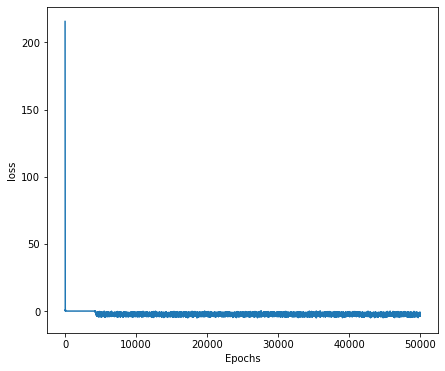

In [10]:
plt.figure(figsize=(7,6))
plt.plot(loss_vector)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

**Loading "best approximation" training**

In [11]:
model.load_state_dict(torch.load('best_approx.mdl'))

<All keys matched successfully>

**Plotting results**

In [12]:
with torch.no_grad():
    x1 = torch.linspace(0.,1,100)
    x1 = x1.flatten()[:, None]
    y_hat = model(x1)
    y_real = torch.sin(np.pi*x1)

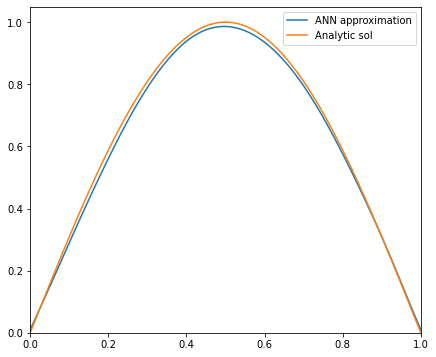

In [13]:
plt.figure(figsize=(7,6))
plt.plot(x1,y_hat,label='ANN approximation')
plt.plot(x1,y_real, label='Analytic sol')
#
plt.xlim(0,1)
plt.ylim(0,None)
#
plt.legend()